In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

class ClassificationDataset(Dataset):
    def __init__(self, healthy_dir, diseased_dir):
    
        self.healthy_files = sorted(glob.glob(os.path.join(healthy_dir, "*.*")))
        self.diseased_files = sorted(glob.glob(os.path.join(diseased_dir, "*.*")))
        
        self.data = []
        for f in self.healthy_files:
            self.data.append((f, 0)) 
            
        for f in self.diseased_files:
            self.data.append((f, 1)) 
            
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img)
        return img_tensor, label

pasta_saudaveis = './dataset_treino' 
pasta_doentes = './dataset_teste'    

try:
    dataset = ClassificationDataset(pasta_saudaveis, pasta_doentes)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    print(f"✅ Dataset criado com {len(dataset)} imagens.")
    print(f"   - Saudáveis (Label 0): {len(dataset.healthy_files)}")
    print(f"   - Doentes   (Label 1): {len(dataset.diseased_files)}")
except Exception as e:
    print(f"❌ Erro ao carregar pastas: {e}")

Usando dispositivo: cuda
✅ Dataset criado com 150 imagens.
   - Saudáveis (Label 0): 50
   - Doentes   (Label 1): 100


In [2]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import os

print("🧠 Baixando modelo pré-treinado...")
model = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
print(f"🚀 Iniciando treinamento por {num_epochs} épocas...")

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_acc = 100 * correct / total
    print(f"Época [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(dataloader):.4f} | Acurácia: {epoch_acc:.2f}%")

print("Treinamento concluído!")

if not os.path.exists('weights'):
    os.makedirs('weights')

save_path = 'weights/gradcam_model_state_dict.pth'
torch.save(model.state_dict(), save_path)
print(f" Modelo salvo em: {save_path}")

🧠 Baixando modelo pré-treinado...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ACER NITRO/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:09<00:00, 5.03MB/s]


🚀 Iniciando treinamento por 10 épocas...
Época [1/10] | Loss: 0.2923 | Acurácia: 90.00%
Época [2/10] | Loss: 0.0656 | Acurácia: 98.00%
Época [3/10] | Loss: 0.0123 | Acurácia: 100.00%
Época [4/10] | Loss: 0.0097 | Acurácia: 100.00%
Época [5/10] | Loss: 0.0041 | Acurácia: 100.00%
Época [6/10] | Loss: 0.0073 | Acurácia: 100.00%
Época [7/10] | Loss: 0.0038 | Acurácia: 100.00%
Época [8/10] | Loss: 0.0052 | Acurácia: 100.00%
Época [9/10] | Loss: 0.0014 | Acurácia: 100.00%
Época [10/10] | Loss: 0.0184 | Acurácia: 98.67%
🏁 Treinamento concluído!
💾 Modelo salvo em: weights/gradcam_model_state_dict.pth


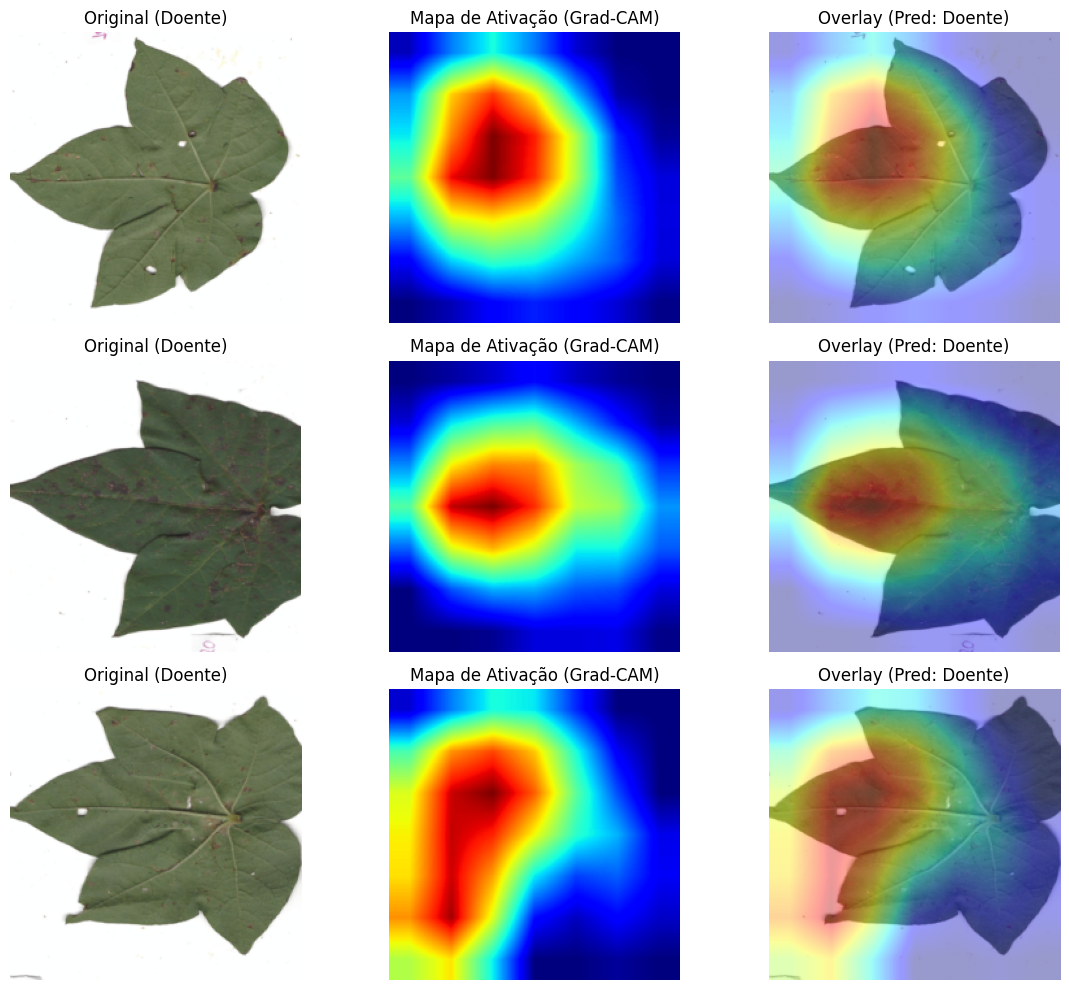

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gerar_gradcam(model, image_tensor, target_layer):
    gradients = []
    activations = []
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
        
    def forward_hook(module, input, output):
        activations.append(output)
        
    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)
    
    model.eval()
    output = model(image_tensor.unsqueeze(0))
    
    pred_idx = output.argmax(dim=1).item()
    
    model.zero_grad()
    output[0, pred_idx].backward()


    grads = gradients[0].cpu().data.numpy()[0] # Gradientes
    fmap = activations[0].cpu().data.numpy()[0] # Mapa de características (Feature Map)
    
    handle_b.remove()
    handle_f.remove()
    
    weights = np.mean(grads, axis=(1, 2))
    
    # Multiplicar os pesos pelo mapa de características
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]
        
    cam = np.maximum(cam, 0)
    
    # Normalizar para 0 a 1
    cam = cam / (cam.max() + 1e-8)
    
    # Redimensionar para o tamanho original da imagem (224x224)
    cam = cv2.resize(cam, (224, 224))
    
    return cam, pred_idx

# 2. Configurar Teste
# Pegar um lote de imagens do nosso DataLoader
images, labels = next(iter(dataloader))
images = images.to(device)

# Vamos escolher apenas as imagens que são DOENTES (Label 1) para visualizar
indices_doentes = [i for i, label in enumerate(labels) if label == 1]

# 3. Gerar e Plotar
plt.figure(figsize=(12, 10))

# Mostrar até 3 exemplos
count = 0
for idx in indices_doentes[:3]:
    img_tensor = images[idx]
    
    # Chama a função Grad-CAM na layer4 (última camada convolucional da ResNet)
    heatmap, pred = gerar_gradcam(model, img_tensor, model.layer4[-1])
    
    # Processar imagem original para exibir
    img_original = img_tensor.cpu().permute(1, 2, 0).numpy()
    # Desfazer normalização ImageNet para ficar bonita
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_original = std * img_original + mean
    img_original = np.clip(img_original, 0, 1)
    
    # Criar sobreposição (Overlay)
    # Converter heatmap para cores (Vermelho = Importante)
    heatmap_colored = plt.get_cmap('jet')(heatmap)[:, :, :3]
    overlay = 0.6 * img_original + 0.4 * heatmap_colored
    
    # Plot
    plt.subplot(3, 3, count*3 + 1)
    plt.imshow(img_original)
    plt.title("Original (Doente)")
    plt.axis('off')
    
    plt.subplot(3, 3, count*3 + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Mapa de Ativação (Grad-CAM)")
    plt.axis('off')
    
    plt.subplot(3, 3, count*3 + 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (Pred: {'Doente' if pred==1 else 'Saudável'})")
    plt.axis('off')
    
    count += 1

plt.tight_layout()
plt.show()